In [1]:
import os
import sys
import json
import h5py
import torch

from tqdm.notebook import trange, tqdm

import numpy   as np 

import os.path as osp
import torch_geometric as pyg
import torch_geometric.transforms as T
from torch_geometric import utils

from numpy           import random
from warnings        import warn

random.seed(12345)
root = "/eos/user/m/mjalalva/Run1/June4/"

Extension horovod.torch has not been built: /cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/horovod/torch/mpi_lib_v2.cpython-39-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


In [2]:
class IndexingSystem(object):
    """
    An indexing system based on metadata defined on multiple files.
    
    Example of allowed metadata:
        {"1" :  {"file1":"62", "file2":"13", "file3":"24"},
         "2" :  {"file2":"2", "file5":"33", "file6":"245"},
         "14":  {"file1":"21", "file2":"23", "file3":"34"}}
    Here, we have three classes of data distributed in six files.
    
    For many puposes, we may want to collect a sample flom these 
    ambigious databases without distruction and recunstruction.
    
    This system let us to map a given index into a data inside 
    the database. Also, it allows us to do sampling over database.
    """
    
    def __init__(self, metadata, collection, **sampling_strategy):
        self._MD         = metadata    # Metadata
        self._MDSummary  = dict()      # Metadata Summary
        self._SampleMD   = dict()      # Sample Metadata
        self._SMDInfo    = dict()      # Sample Metadata Information (= Summary)
        self._filenames  = None        # File Names Container
        self._No_SamData = None        # Number of sampled data we can access through this IndexingSystem
        self._No_TotData = None        # Number of total data we can access through this IndexingSystem
        
        self._summarize()
        self._smaple_from_collection(collection, **sampling_strategy)
        
    def _summarize(self):
        """ 
        Sumerizing the metadata:
            1. List of files
            2. Dictionary for pu - #pu pair; i.e. DICT[PU] = #PU
        """
        files = set()
        for PU in self._MD:
            PU_MD = self._MD[PU]
            current_PU = 0
            for file_name in PU_MD:
                files.add(file_name)
                current_PU += int(PU_MD[file_name])
               
            self._MDSummary[PU] = current_PU
        self._filenames = list(files)
                        
    def _DCPrep(self, data_col:dict):
        """
        Data collection preprocessing:
            1. filtering mising pu's
            2. Avoiding overflow
        """
        rejected = dict()
        for PU in data_col:
            try:
                wanted_PU    = data_col[PU]
                available_PU = self._MDSummary[PU]
            except KeyError:
                warn(f"PU = {PU} is not available. Excluding PU = {PU} ...")
                rejected[PU] = data_col[PU]
                # Excluding ...
                continue
            if available_PU < wanted_PU:
                w = f"PU = {PU} overflows... Setting PU = {PU} to {available_PU} instead of {wanted_PU}"
                warn(w)
                wanted_PU = available_PU
                
            self._SampleMD[PU] = wanted_PU
        self._No_SamData = np.sum(list(self._SampleMD.values()))
        return rejected
    
    def _smaple_from_collection(self, dc:dict, **sampling_kwargs):
        """
        Random sampling of the whole data from sample metadata
        """
        rejected_PU    = self._DCPrep(dc)        
        for PU in self._SampleMD:
            PU=str(int(PU))
            self._SMDInfo[PU] = random.choice(range(int(self._MDSummary[PU])), size=int(self._SampleMD[PU]), **sampling_kwargs)        
    
    def _GETITEM(SELF, CONTAINER_DICT, IND):
        """
        Assuming `CONTAINER_DICT` has a shape as `self._MDSummary` i.e. {cls_i: `freq of cls_i`}.
        In this case, indexing is over "All" classes not a specific one. 
        Knowing the frequency of each class, we iterate over `CONTAINER_DICT` to find "local" index.
        In summary, we want to find the `class` and local index corresponding to a given `IND`.
        """
        
        for key in CONTAINER_DICT:
            IND -= CONTAINER_DICT[key]
            if IND < 0 :
                IND += CONTAINER_DICT[key]
                return key, IND
        raise IndexError
    
    def _map_index(self, ind):
        """
        `ind` is a "global" index i.e. defind over all "sampled" data.
        Trivially, each "global" index is reffered to a "local" index.
        It is mapped into a local index of a given PU associated with `ind`.
        """
#         print(self._SMDInfo)
        PU, ind = self._GETITEM(self._SampleMD, ind)
#         print(PU, ind)
        real_index = self._SMDInfo[PU][int(ind)]
        return PU, real_index
    
    def _getitem(self, ind):
        """
        This method do the final job of index processing system.
        It returns all information in order to load the data.
        """
        PU, PU_index = self._map_index(ind) 
        PU_MD = self._MD[PU]
        file_name, infile_index = self._GETITEM(PU_MD, PU_index)
        return file_name, PU, infile_index
    
    @property
    def num_available_data(self):
        """
        Returns the number of sampled data
        """
        return self._No_SamData
   
    @property
    def num_all_data(self):
        """
        Returns the number of allowed data
        """
        return self._No_TotData

    @property
    def files(self):
        """
        Returns the file names
        """
        return self._filenames
    
    @property
    def keys(self):
        """
        Returns available PU classes
        """
        return self._SampleMD.keys()  
    
class GraphDataset(IndexingSystem, pyg.data.Dataset):
    
    def __init__(self, root, metadata_dir, sample_metadata,
                 sampling_strategy={"replace":False, "p":None},
                 transform=None, pre_transform=None, pre_filter=None, log=False):
        
        if isinstance(root, str):
            root = osp.expanduser(osp.normpath(root))
        
        with open(osp.join(root, "metadata" ,metadata_dir), "r") as jsonfile:
            metadata_dict = json.load(jsonfile)
        
        super().__init__(metadata_dict, sample_metadata, **sampling_strategy)
        
        self.root          = root
        self.mddir         = metadata_dir
        self.transform     = transform
        self.pre_transform = pre_transform
        self.pre_filter    = pre_filter
        self.log           = log
        self._indices      = None
        self._files        = dict()
                
        self.process()
        
        self._map_classes = dict(zip(self.keys, list(range(self.num_classes))))
        
    def map_class(self, data):
        data.y = self._map_classes[str(int(data.y))]
    
    def process(self):
        """Opening all files with read-only mode"""
        if self.log and 'pytest' not in sys.modules:
            print('Processing...', file=sys.stderr)
        for filename in self.files:
            path_to_file = osp.join(self.root, filename + ".h5")
            self._files[filename] = h5py.File(path_to_file, "r")
        if self.log and 'pytest' not in sys.modules:
            print('Done!', file=sys.stderr)
    
    def len(self):
        """Returns length of dataset i.e. numberr of graphs in dataset"""
        return int(self.num_available_data)
    
    def indices(self):
        """Returns indices array in increasing order"""
        return range(self.len()) if self._indices is None else self._indices

    def get(self, idx):
        """
        Returns the data associated with `idx` under our inherited `IndexingSystem`
        """
        filename, PU, infile_index = IndexingSystem._getitem(self, idx)
        raw_data = self._files[filename][f"PU{PU}"][f"E{infile_index}"][0]
        
        if self.pre_filter is not None:
            raw_data = self.pre_filter(raw_data)
        
        if self.pre_transform is not None:
            raw_data = self.pre_transform(raw_data)
        
        data = to_data(raw_data, filename, PU, infile_index)
        
        if self.transform is not None:
            data = self.transform(data)
            
        # Checking the data is cleaned:
        if data.x.isnan().sum() + data.edge_index.isnan().sum() + data.edge_attr.isnan().sum() > 0:
            s = f"The record {idx} at {filename}: {PU}: {infile_index} contains nan."
            warn(s)
#         self.map_class(data)
        return data
    
    def file_dir(self) -> str:
        """
        Returns direcotry of files in which are located.
        It is assumed all files are in '~root/data/' directory.
        """
        return osp.join(self.root, 'data')
    
    @property
    def num_classes(self) -> int:
        r"""Returns the number of classes in the dataset."""
        return len(self.keys)
    
    @property
    def num_node_features(self) -> int:
        r"""Returns the number of features per node in the dataset."""
        data = self[0] 
        
        if hasattr(data, 'num_node_features'):
            return data.num_node_features
        
        raise AttributeError(f"'{data.__class__.__name__}' object has no "
                             f"attribute 'num_node_features'")
    
    @property
    def num_edge_features(self) -> int:
        r"""Returns the number of features per edge in the dataset."""
        data = self[0]
        if hasattr(data, 'num_edge_features'):
            return data.num_edge_features
        
        raise AttributeError(f"'{data.__class__.__name__}' object has no "
                             f"attribute 'num_edge_features'")

        
def remove_nan_node(node_features, edge_index, edge_attributes):    
    node_ID, feature_ID = np.where(np.isnan(node_features))
    node_features       = np.delete(node_features, node_ID, axis=0)
    
    for node in node_ID:
        _, edge    = np.where(edge_index == node)
        edge_index = np.delete(edge_index, edge, axis=1)
        edge_attributes = np.delete(edge_attributes, edge, axis=0)
    
    return node_features, edge_index, edge_attributes
    
    
def to_data(raw_data, *args):
    nf = np.array(raw_data["node_features"])
    ea = np.array(raw_data["edge_attributes"])
    ei = np.array(raw_data["edge_indecies"], dtype=np.int64)
    gf = np.array(raw_data["graph_features"])
    gl = np.array(raw_data["graph_labels"], dtype=np.int64)
    
    edge_indecies, edge_weights = utils.to_undirected(torch.from_numpy(ei), torch.from_numpy(ea))
    
    if np.isnan(nf).sum() > 0:
        nf, ei, ea = remove_nan_node(node_features=nf, edge_index=ei, edge_attributes=ea)
        with open("/eos/user/c/cmstandi/SWAN_projects/saleh-highlights/strange_data.txt", "a") as log:
            print("'{}' : 'PU={}' : 'E{}'".format(*args), file=log)
            
    return pyg.data.Data(x         =torch.from_numpy(nf),
                    edge_index     =edge_indecies,
                    edge_attr      =edge_weights,
                    graph_features =torch.from_numpy(gf),
                    y              =torch.from_numpy(gl)
                 )



In [3]:
with open(osp.join(root, "Summary.json"), "r") as j:
    meta = json.load(j)

sample = meta.copy()

for k, v in meta.items():
    if len(v) == 0:
        sample.pop(k)

collec = dict(zip(list(sample.keys()), np.ones(len(meta))*3000 ))
dataset = GraphDataset(root=root, metadata_dir="Summary.json",sample_metadata=collec)

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[500]  # Get the first graph object.

print()
print(data)
print('=======================================================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: GraphDataset(150000):
Number of graphs: 150000
Number of features: 9
Number of classes: 50

Data(x=[1712, 9], edge_index=[2, 5690], edge_attr=[5690], y=[1], graph_features=[2, 1])
Number of nodes: 1712
Number of edges: 5690
Average node degree: 3.32
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [5]:
inds = np.random.choice(list(range(150000)), replace=False, size=1000)

In [6]:
sampled_data = dataset[inds]  # Smapling the dataset

In [7]:
graph_features = [data.graph_features for data in sampled_data]
graph_features = torch.cat(graph_features, axis = 1)
PU = [data.y.item() for data in sampled_data]

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
data_frame = pd.DataFrame(dict(nVertices = graph_features[0], nVGoodVertices = graph_features[1], PU = PU))

In [12]:
data_frame.corr()

,nVertices,nVGoodVertices,PU
nVertices,1.000000,0.981244,-0.034612
nVGoodVertices,0.981244,1.000000,-0.021593
PU,-0.034612,-0.021593,1.000000


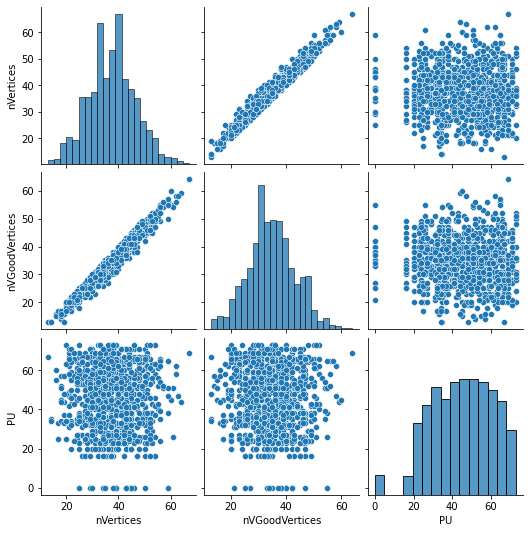

In [15]:
sns.pairplot(data_frame)

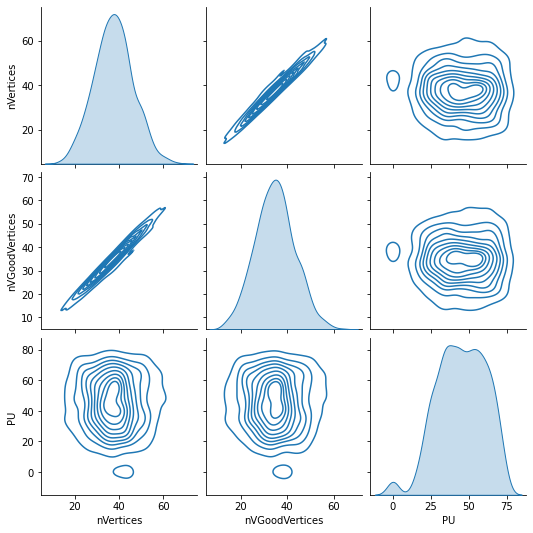

In [16]:
sns.pairplot(data_frame, kind="kde")

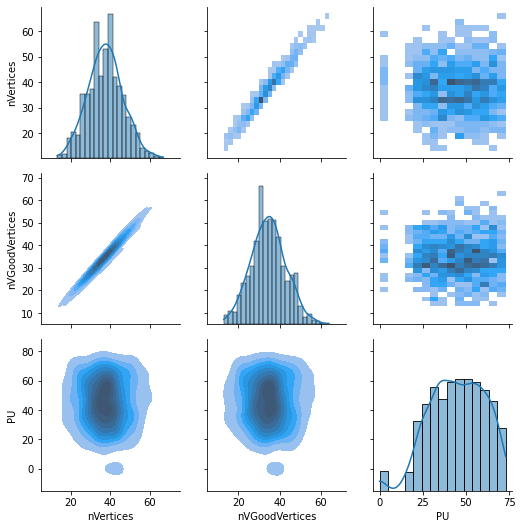

In [19]:
g = sns.PairGrid(data_frame)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

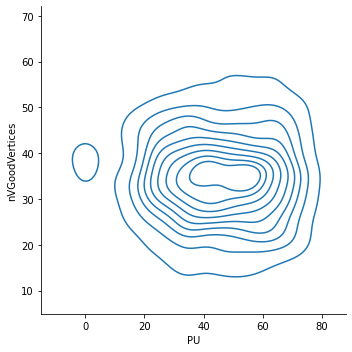

In [18]:
sns.displot(data_frame, x="PU", y="nVGoodVertices", kind="kde")